### Created by: Anthony D. Cho
### Last update: 06.12.2021

**Subject**: Classification (CNN, transfer learning - keras, tensorflow) - Flowers Recognition


In [1]:
## Librerias generales
import os
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from numpy import zeros, array, argmax, vstack

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## Keras tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

### Customized function

In [2]:
## Performance model display function
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()
    
## Feature extraction function
def featureExtraction(model, datagenerator):
    """
        DESCRIPTION:
            Feature extraction from a dataset generator using a given model
        
        INPUT:
            @param model: model
            @type model: tensorflow.keras.Functional
            
            @param datagenerator: image loader generator
            @type datagenerator: tensorflow.keras.preprocessing.image.DirectoryIterator
        
        OUTPUT:
            @param X: features matrix
            @param X: numpy.ndarray
            
            @param y: One-hot encoded label matrix
            @param y: numpy.ndarray
    """
    start = time()
    
    ## Reset generator index
    datagenerator.reset()
    
    ## batch size
    batch = datagenerator.batch_size

    ## Number of steps to cover all batches from the generator
    step = datagenerator.samples // batch

    ## Number of total images covered for feature extraction
    N = (datagenerator.samples // batch)*batch

    ## Targets allocation
    y = zeros((N, datagenerator.num_classes))

    i = 0
    for _, label in datagenerator:
        
      ## shifting index for allocation
      s, t = batch*i, batch*(i+1)
      y[s:t] = label

      ## Stop loop when it cover almost all imagen
      if i == step-1:
        break
      i += 1
    print('Encoded labels: {}'.format(y.shape))

    ## Reset generator index
    datagenerator.reset()

    ## Compute feature extraction
    X = model.predict(datagenerator, steps=step)
    print('Features matrix shape: {}'.format(X.shape))

    ## Reshaping features matrix
    X = X.reshape(len(X), -1)
    print('Features reshaped matrix: {}'.format(X.shape))
    
    ## report time spent
    print('Time spent[s]: {}'.format(time() -start))
    
    ## return features matrix and target label
    return X, y

## Labels extraction from generator
def labelsExtraction_fromGenerator(dataGenerator):
    """
         DESCRIPTION:
            Labels extraction from a dataset generator
        
        INPUT:
            @param datagenerator: image loader generator
            @type datagenerator: tensorflow.keras.preprocessing.image.DirectoryIterator
        
        OUTPUT:
            @param y: label list
            @param y: list
    """

    batch = dataGenerator.batch_size
    step = dataGenerator.samples // batch

    ## Ground truth labels
    y_true = []

    i = 0
    for _, label in dataGenerator:
        y_true.extend( label.argmax(axis=-1).tolist() )
        if i == step-1:
          break
        i += 1

    ## return labels
    return y_true

**Data source:**

[Flowers classification](https://www.kaggle.com/alxmamaev/flowers-recognition) (Classification)

In [3]:
if not os.path.exists("dataFlowers.zip"):
    ## Download files

    !wget https://github.com/adoc-box/Datasets/blob/main/flowers.zip?raw=true
    !wget https://github.com/adoc-box/Datasets/blob/main/flowers.z01?raw=true

    !mv flowers.zip\?raw\=true flowers.zip
    !mv flowers.z01\?raw\=true flowers.z01

    ## join files 
    !zip -F flowers.zip --out dataFlowers.zip

    ## remove some files
    !rm flowers.z01 flowers.zip

    ## un-compress joined zip file
    !unzip dataFlowers.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 copying: data/train/rose/3576488381_611f3446e0_n.jpg
 copying: data/train/rose/3624546109_8eb98f0cdb.jpg
 copying: data/train/rose/3634244527_e72c47842c_n.jpg
 copying: data/train/rose/3654988152_b11178bbcb.jpg
 copying: data/train/rose/3655527028_0fab2b547d_n.jpg
 copying: data/train/rose/3661675690_ed2d05fa5f_n.jpg
 copying: data/train/rose/3664842094_5fd60ee26b.jpg
 copying: data/train/rose/3667366832_7a8017c528_n.jpg
 copying: data/train/rose/3873271620_1d9d314f01_n.jpg
 copying: data/train/rose/3909587261_f8cd3e7fe7.jpg
 copying: data/train/rose/394990940_7af082cf8d_n.jpg
 copying: data/train/rose/4061451210_1650590c6a.jpg
 copying: data/train/rose/4093390305_4010c736c9.jpg
 copying: data/train/rose/410421672_563550467c.jpg
 copying: data/train/rose/410425647_4586667858.jpg
 copying: data/train/rose/4242976586_607a8f9843_n.jpg
 copying: data/train/rose/4279989256_9a48c0d194_n.jpg
 copying: data/train/rose/42799908

### Image loader generator

In [4]:
## Images PATHs
train_dir = 'data/train/'
validation_dir = 'data/validation/'
test_dir = 'data/test/'

## Image generator instances
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Image conversion size
imgSize = 150

## Generator setting (Train)
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to (imgSize x imgSize)
        target_size=(imgSize, imgSize), ## 224
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

## Generator setting (Validation)
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

## Generator setting (test)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

Found 2313 images belonging to 5 classes.
Found 554 images belonging to 5 classes.
Found 380 images belonging to 5 classes.


### Features extraction from a pre-trained neural model

In [5]:
## Base model
baseModel = VGG16(include_top=False, ## top layers (classifier) not included
                  weights='imagenet', ## load pre-trained weights from imagenet
                  input_shape=(imgSize, imgSize, 3) ## Input shape
                  )

## Display base model
baseModel.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [6]:
## Apply feature extracion
X_train, y_train = featureExtraction(model=baseModel, datagenerator=train_generator)
X_val, y_val = featureExtraction(model=baseModel, datagenerator=validation_generator)
X_test, y_test = featureExtraction(model=baseModel, datagenerator=test_generator)

Encoded labels: (2300, 5)
Features matrix shape: (2300, 4, 4, 512)
Features reshaped matrix: (2300, 8192)
Time spent[s]: 30.15737509727478
Encoded labels: (540, 5)
Features matrix shape: (540, 4, 4, 512)
Features reshaped matrix: (540, 8192)
Time spent[s]: 4.6013734340667725
Encoded labels: (380, 5)
Features matrix shape: (380, 4, 4, 512)
Features reshaped matrix: (380, 8192)
Time spent[s]: 3.344116449356079


#### Random Forest as classifier

In [7]:
## Instance and model fitting
RandomForest = RandomForestClassifier(criterion='entropy').fit(X_train, y_train.argmax(axis=1))

## Compute prediction
predictions = RandomForest.predict(X_test)

## Compute score
print('Score (Train): {}'.format(RandomForest.score(X_train, y_train.argmax(axis=1))))
print('Score (Test): {}'.format(RandomForest.score(X_test, y_test.argmax(axis=1))))

Score (Train): 0.9995652173913043
Score (Test): 0.6973684210526315


In [8]:
## Display confusion matrix
print( confusion_matrix(y_true=y_test.argmax(axis=1), y_pred=predictions) )

## Display classification report
print( classification_report(y_true=y_test.argmax(axis=1), y_pred=predictions) )

[[43 10  6  7  4]
 [ 3 69  4  6  8]
 [ 2  3 52  3 10]
 [ 6  8  3 46  8]
 [ 0  8 11  5 55]]
              precision    recall  f1-score   support

           0       0.80      0.61      0.69        70
           1       0.70      0.77      0.73        90
           2       0.68      0.74      0.71        70
           3       0.69      0.65      0.67        71
           4       0.65      0.70      0.67        79

    accuracy                           0.70       380
   macro avg       0.70      0.69      0.70       380
weighted avg       0.70      0.70      0.70       380



#### Naive Bayes as classifier

In [9]:
Bayes = GaussianNB().fit(X_train, y_train.argmax(axis=1))

## Compute prediction
predictions = Bayes.predict(X_test)

## Compute score
print('Score (Train): {}'.format(Bayes.score(X_train, y_train.argmax(axis=1))))
print('Score (Test): {}'.format(Bayes.score(X_test, y_test.argmax(axis=1))))

Score (Train): 0.8265217391304348
Score (Test): 0.45789473684210524


In [10]:
## Display confusion matrix
print( confusion_matrix(y_true=y_test.argmax(axis=1), y_pred=predictions) )

## Display classification report
print( classification_report(y_true=y_test.argmax(axis=1), y_pred=predictions) )

[[33  7  5 11 14]
 [13 44  7 18  8]
 [ 6  9 32  7 16]
 [13  8  2 35 13]
 [15  8 12 14 30]]
              precision    recall  f1-score   support

           0       0.41      0.47      0.44        70
           1       0.58      0.49      0.53        90
           2       0.55      0.46      0.50        70
           3       0.41      0.49      0.45        71
           4       0.37      0.38      0.38        79

    accuracy                           0.46       380
   macro avg       0.47      0.46      0.46       380
weighted avg       0.47      0.46      0.46       380



#### MLP as classifier

In [11]:
## Model instance
model = Sequential(name='MLP_Classifier')
model.add(layers.Dense(units=2048, activation='relu', 
                       input_shape=(X_train.shape[1],), 
                       name='Hidden_01'))
model.add(layers.Dropout(rate=0.5, name='Dropout_01'))
model.add(layers.Dense(units=512, activation='relu', name='Hidden_02'))
model.add(layers.Dense(units=5, activation='softmax', name='output'))

model.summary()

Model: "MLP_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_01 (Dense)           (None, 2048)              16779264  
                                                                 
 Dropout_01 (Dropout)        (None, 2048)              0         
                                                                 
 Hidden_02 (Dense)           (None, 512)               1049088   
                                                                 
 output (Dense)              (None, 5)                 2565      
                                                                 
Total params: 17,830,917
Trainable params: 17,830,917
Non-trainable params: 0
_________________________________________________________________


In [12]:
start = time()

## Comiler settings
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

## Model fitting
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), 
                    batch_size=20, epochs=30)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

Epoch 1/30
115/115 [==============================] - 2s 14ms/step - loss: 1.4469 - accuracy: 0.5426 - val_loss: 0.7655 - val_accuracy: 0.7185
Epoch 2/30
115/115 [==============================] - 1s 11ms/step - loss: 0.7266 - accuracy: 0.7339 - val_loss: 0.7950 - val_accuracy: 0.6926
Epoch 3/30
115/115 [==============================] - 1s 12ms/step - loss: 0.5815 - accuracy: 0.7830 - val_loss: 0.6958 - val_accuracy: 0.7537
Epoch 4/30
115/115 [==============================] - 1s 12ms/step - loss: 0.4950 - accuracy: 0.8217 - val_loss: 0.6773 - val_accuracy: 0.7685
Epoch 5/30
115/115 [==============================] - 1s 12ms/step - loss: 0.4598 - accuracy: 0.8296 - val_loss: 0.7727 - val_accuracy: 0.7481
Epoch 6/30
115/115 [==============================] - 1s 11ms/step - loss: 0.3621 - accuracy: 0.8670 - val_loss: 0.7073 - val_accuracy: 0.7667
Epoch 7/30
115/115 [==============================] - 1s 12ms/step - loss: 0.3193 - accuracy: 0.8826 - val_loss: 0.7594 - val_accuracy: 0.7519

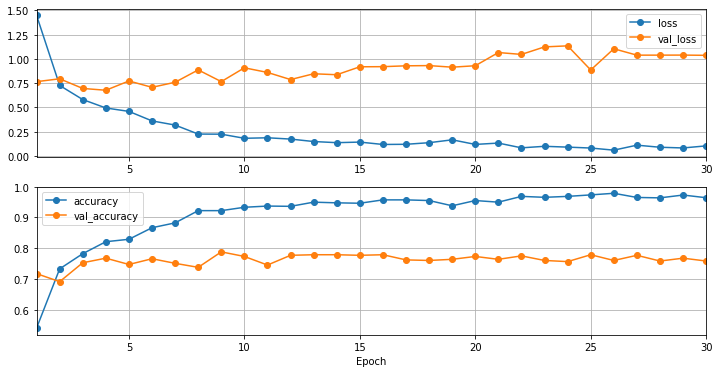

In [13]:
plot_history(history=history)

In [14]:
## Compute prediction
predictions = model.predict(X_test)

## Compute score
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 7ms/step - loss: 0.8195 - accuracy: 0.7842


[0.8194926381111145, 0.7842105031013489]

In [15]:
## display confusion matrix
print(confusion_matrix(y_true=y_test.argmax(axis=1), 
                       y_pred=predictions.argmax(axis=1)))

## display classification report
print(classification_report(y_true=y_test.argmax(axis=1), 
                            y_pred=predictions.argmax(axis=1)))

[[51  4  9  2  4]
 [ 6 67  6  6  5]
 [ 0  1 58  1 10]
 [ 1  1  2 62  5]
 [ 2  5  9  3 60]]
              precision    recall  f1-score   support

           0       0.85      0.73      0.78        70
           1       0.86      0.74      0.80        90
           2       0.69      0.83      0.75        70
           3       0.84      0.87      0.86        71
           4       0.71      0.76      0.74        79

    accuracy                           0.78       380
   macro avg       0.79      0.79      0.79       380
weighted avg       0.79      0.78      0.79       380



##### Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 9 (accuracy metric).

In [16]:
## Joining X_train and X_val
X = vstack([X_train, X_val])
y = vstack([y_train, y_val])

print('(Shape) X: {}, y: {}'.format(X.shape, y.shape))

(Shape) X: (2840, 8192), y: (2840, 5)


In [17]:
## Model instance
model = Sequential(name='MLP_Classifier')
model.add(layers.Dense(units=2048, activation='relu', 
                       input_shape=(X.shape[1],), 
                       name='Hidden_01'))
model.add(layers.Dropout(rate=0.5, name='Dropout_01'))
model.add(layers.Dense(units=512, activation='relu', name='Hidden_02'))
model.add(layers.Dense(units=5, activation='softmax', name='output'))

start = time()

## Comiler settings
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

## Model fitting
history = model.fit(x=X, y=y, batch_size=20, epochs=9)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

Epoch 1/9
142/142 [==============================] - 2s 11ms/step - loss: 1.3118 - accuracy: 0.5588
Epoch 2/9
142/142 [==============================] - 1s 10ms/step - loss: 0.7427 - accuracy: 0.7232
Epoch 3/9
142/142 [==============================] - 1s 10ms/step - loss: 0.5934 - accuracy: 0.7905
Epoch 4/9
142/142 [==============================] - 1s 10ms/step - loss: 0.5247 - accuracy: 0.8067
Epoch 5/9
142/142 [==============================] - 1s 10ms/step - loss: 0.4531 - accuracy: 0.8331
Epoch 6/9
142/142 [==============================] - 1s 10ms/step - loss: 0.3674 - accuracy: 0.8687
Epoch 7/9
142/142 [==============================] - 1s 10ms/step - loss: 0.3394 - accuracy: 0.8810
Epoch 8/9
142/142 [==============================] - 1s 10ms/step - loss: 0.2641 - accuracy: 0.9088
Epoch 9/9
142/142 [==============================] - 1s 10ms/step - loss: 0.2598 - accuracy: 0.9092

Time spent[s]: 14.11


In [18]:
## Compute prediction
predictions = model.predict(X_test)

In [19]:
## display confusion matrix
print(confusion_matrix(y_true=y_test.argmax(axis=1), 
                       y_pred=predictions.argmax(axis=1)))

## display classification report
print(classification_report(y_true=y_test.argmax(axis=1), 
                            y_pred=predictions.argmax(axis=1)))

[[47 10  3  2  8]
 [ 1 77  2  5  5]
 [ 1  2 41  0 26]
 [ 2  2  0 58  9]
 [ 2  6  1  1 69]]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        70
           1       0.79      0.86      0.82        90
           2       0.87      0.59      0.70        70
           3       0.88      0.82      0.85        71
           4       0.59      0.87      0.70        79

    accuracy                           0.77       380
   macro avg       0.80      0.76      0.77       380
weighted avg       0.80      0.77      0.77       380



### Freezing base model

In [25]:
## Reset generator index
train_generator.reset()
validation_generator.reset()

In [26]:
## Base model
baseModel = VGG16(include_top=False, weights='imagenet', input_shape=(imgSize, imgSize, 3))

## Adding a MLP on top of base model
model = Sequential(name='Freeze_baseModel')
model.add(baseModel)
model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(2048, activation='relu', name='Dense_01'))
model.add(layers.Dropout(rate=0.5, name='Dropout'))
model.add(layers.Dense(512, activation='relu', name='Dense_02'))
model.add(layers.Dense(5, activation='softmax', name='output'))

## Freezing base model
baseModel.trainable = False

## model display
model.summary()

Model: "Freeze_baseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 8192)              0         
                                                                 
 Dense_01 (Dense)            (None, 2048)              16779264  
                                                                 
 Dropout (Dropout)           (None, 2048)              0         
                                                                 
 Dense_02 (Dense)            (None, 512)               1049088   
                                                                 
 output (Dense)              (None, 5)                 2565      
                                                                 
Total params: 32,545,605
Trainable params: 17,830,

In [27]:
start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

## Model fitting
history = model.fit(train_generator, steps_per_epoch=115, 
                    validation_data=validation_generator, validation_steps=27, 
                    epochs=20)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

Epoch 1/20
115/115 [==============================] - 19s 161ms/step - loss: 1.3380 - accuracy: 0.5556 - val_loss: 0.7689 - val_accuracy: 0.7241
Epoch 2/20
115/115 [==============================] - 18s 158ms/step - loss: 0.7338 - accuracy: 0.7392 - val_loss: 0.8045 - val_accuracy: 0.6944
Epoch 3/20
115/115 [==============================] - 18s 158ms/step - loss: 0.5988 - accuracy: 0.7737 - val_loss: 0.7431 - val_accuracy: 0.7296
Epoch 4/20
115/115 [==============================] - 18s 159ms/step - loss: 0.4872 - accuracy: 0.8308 - val_loss: 0.6784 - val_accuracy: 0.7556
Epoch 5/20
115/115 [==============================] - 18s 159ms/step - loss: 0.4159 - accuracy: 0.8495 - val_loss: 0.6984 - val_accuracy: 0.7611
Epoch 6/20
115/115 [==============================] - 18s 159ms/step - loss: 0.3645 - accuracy: 0.8635 - val_loss: 0.7721 - val_accuracy: 0.7593
Epoch 7/20
115/115 [==============================] - 18s 159ms/step - loss: 0.3024 - accuracy: 0.8914 - val_loss: 0.8141 - val_ac

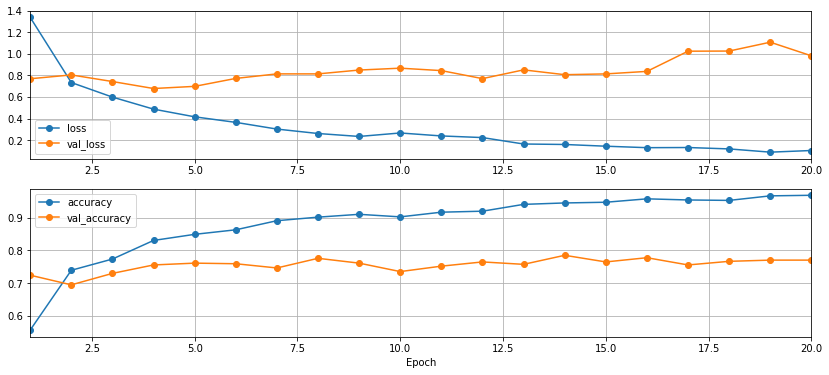

19/19 [==============================] - 3s 128ms/step - loss: 0.8021 - accuracy: 0.7974
[0.8021138310432434, 0.7973684072494507]


In [28]:
## Reset test generator index
test_generator.reset()

## Performances display
plot_history(history, width=14)

## Compute metrics using test data
print(model.evaluate(test_generator, steps=19))

## Reset test generator index
test_generator.reset()

## Compute predictions using test data
prediction = model.predict(test_generator, steps=19)

## Reset test generator index
test_generator.reset()

## Ground truth labels
y_true = labelsExtraction_fromGenerator(test_generator)

In [29]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, 
                       y_pred=prediction.argmax(axis=1)))

## display classification report
print(classification_report(y_true=y_true, 
                            y_pred=prediction.argmax(axis=1)))

[[52  2  7  4  5]
 [ 6 71  2  6  5]
 [ 3  1 52  2 12]
 [ 2  2  0 62  5]
 [ 4  1  4  4 66]]
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        70
           1       0.92      0.79      0.85        90
           2       0.80      0.74      0.77        70
           3       0.79      0.87      0.83        71
           4       0.71      0.84      0.77        79

    accuracy                           0.80       380
   macro avg       0.80      0.80      0.80       380
weighted avg       0.80      0.80      0.80       380



##### Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 14 (accuracy metric).

In [30]:
## Reset generator index
train_generator.reset()
test_generator.reset()

## Base model
baseModel = VGG16(include_top=False, weights='imagenet', input_shape=(imgSize, imgSize, 3))

## Adding a MLP on top of base model
model = Sequential(name='Freeze_baseModel')
model.add(baseModel)
model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(2048, activation='relu', name='Dense_01'))
model.add(layers.Dropout(rate=0.5, name='Dropout'))
model.add(layers.Dense(512, activation='relu', name='Dense_02'))
model.add(layers.Dense(5, activation='softmax', name='output'))

## Freezing base model
baseModel.trainable = False

start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

## Model fitting
history = model.fit(train_generator, steps_per_epoch=115,
                    epochs=14)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

Epoch 1/14
115/115 [==============================] - 16s 129ms/step - loss: 1.3639 - accuracy: 0.5608
Epoch 2/14
115/115 [==============================] - 15s 129ms/step - loss: 0.7537 - accuracy: 0.7183
Epoch 3/14
115/115 [==============================] - 15s 129ms/step - loss: 0.5903 - accuracy: 0.7902
Epoch 4/14
115/115 [==============================] - 15s 130ms/step - loss: 0.5057 - accuracy: 0.8112
Epoch 5/14
115/115 [==============================] - 15s 130ms/step - loss: 0.4151 - accuracy: 0.8495
Epoch 6/14
115/115 [==============================] - 15s 129ms/step - loss: 0.3620 - accuracy: 0.8692
Epoch 7/14
115/115 [==============================] - 15s 130ms/step - loss: 0.3013 - accuracy: 0.8888
Epoch 8/14
115/115 [==============================] - 15s 130ms/step - loss: 0.2445 - accuracy: 0.9110
Epoch 9/14
115/115 [==============================] - 15s 129ms/step - loss: 0.2742 - accuracy: 0.8940
Epoch 10/14
115/115 [==============================] - 15s 129ms/step - l

In [31]:
## Reset test generator index
test_generator.reset()

## Compute metrics using test data
print(model.evaluate(test_generator, steps=19))

## Reset test generator index
test_generator.reset()

## Compute predictions using test data
prediction = model.predict(test_generator, steps=19)

## Reset test generator index
test_generator.reset()

## Ground truth labels
y_true = labelsExtraction_fromGenerator(test_generator)

19/19 [==============================] - 3s 130ms/step - loss: 0.8206 - accuracy: 0.7500
[0.820554792881012, 0.75]


In [32]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, 
                       y_pred=prediction.argmax(axis=1)))

## display classification report
print(classification_report(y_true=y_true, 
                            y_pred=prediction.argmax(axis=1)))

[[56  7  2  3  2]
 [10 73  1  6  0]
 [10  3 37  7 13]
 [ 4  1  0 65  1]
 [ 9  7  3  6 54]]
              precision    recall  f1-score   support

           0       0.63      0.80      0.70        70
           1       0.80      0.81      0.81        90
           2       0.86      0.53      0.65        70
           3       0.75      0.92      0.82        71
           4       0.77      0.68      0.72        79

    accuracy                           0.75       380
   macro avg       0.76      0.75      0.74       380
weighted avg       0.76      0.75      0.75       380



### Partially-Freezing base model

In [33]:
## Reset generator index
train_generator.reset()
validation_generator.reset()

In [34]:
## Base model
baseModel = VGG16(include_top=False, weights='imagenet', input_shape=(imgSize, imgSize, 3))

## Adding a MLP on top of base model
model = Sequential(name='Freeze_baseModel')
model.add(baseModel)
model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(2048, activation='relu', name='Dense_01'))
model.add(layers.Dropout(rate=0.5, name='Dropout'))
model.add(layers.Dense(512, activation='relu', name='Dense_02'))
model.add(layers.Dense(5, activation='softmax', name='output'))

## Freezing base model
baseModel.trainable = False

## Un-freeze base model from a specific layer.
active = False
for layer in baseModel.layers:
  if layer.name == 'block5_conv2':
    active = True

  layer.trainable = True if active else False

## model display
model.summary()

Model: "Freeze_baseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 8192)              0         
                                                                 
 Dense_01 (Dense)            (None, 2048)              16779264  
                                                                 
 Dropout (Dropout)           (None, 2048)              0         
                                                                 
 Dense_02 (Dense)            (None, 512)               1049088   
                                                                 
 output (Dense)              (None, 5)                 2565      
                                                                 
Total params: 32,545,605
Trainable params: 17,830,

In [35]:
start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

## Model fitting
history = model.fit(train_generator, steps_per_epoch=115, 
                    validation_data=validation_generator, validation_steps=27, 
                    epochs=20)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

Epoch 1/20
115/115 [==============================] - 19s 161ms/step - loss: 1.3884 - accuracy: 0.5626 - val_loss: 0.7562 - val_accuracy: 0.7333
Epoch 2/20
115/115 [==============================] - 18s 158ms/step - loss: 0.7032 - accuracy: 0.7414 - val_loss: 0.7204 - val_accuracy: 0.7444
Epoch 3/20
115/115 [==============================] - 18s 158ms/step - loss: 0.5957 - accuracy: 0.7724 - val_loss: 0.6785 - val_accuracy: 0.7593
Epoch 4/20
115/115 [==============================] - 18s 158ms/step - loss: 0.5032 - accuracy: 0.8168 - val_loss: 0.6963 - val_accuracy: 0.7741
Epoch 5/20
115/115 [==============================] - 18s 159ms/step - loss: 0.4454 - accuracy: 0.8373 - val_loss: 0.6528 - val_accuracy: 0.7741
Epoch 6/20
115/115 [==============================] - 18s 158ms/step - loss: 0.3543 - accuracy: 0.8740 - val_loss: 0.8464 - val_accuracy: 0.7426
Epoch 7/20
115/115 [==============================] - 18s 158ms/step - loss: 0.3123 - accuracy: 0.8866 - val_loss: 0.7291 - val_ac

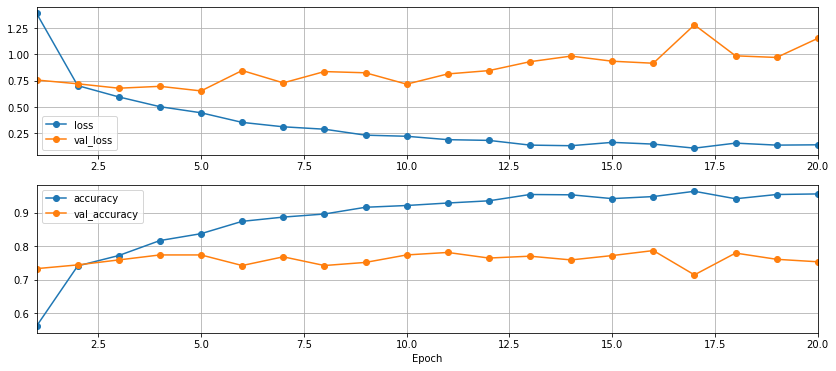

19/19 [==============================] - 3s 128ms/step - loss: 1.1267 - accuracy: 0.7474
[1.1266863346099854, 0.7473683953285217]


In [36]:
## Reset test generator index
test_generator.reset()

## Performances display
plot_history(history, width=14)

## Compute metrics using test data
print(model.evaluate(test_generator, steps=19))

## Reset test generator index
test_generator.reset()

## Compute predictions using test data
prediction = model.predict(test_generator, steps=19)

## Reset test generator index
test_generator.reset()

## Ground truth labels
y_true = labelsExtraction_fromGenerator(test_generator)

In [37]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, 
                       y_pred=prediction.argmax(axis=1)))

## display classification report
print(classification_report(y_true=y_true, 
                            y_pred=prediction.argmax(axis=1)))

[[39 13  5  6  7]
 [ 0 80  0  7  3]
 [ 1  6 41  3 19]
 [ 1  5  0 60  5]
 [ 0  9  3  3 64]]
              precision    recall  f1-score   support

           0       0.95      0.56      0.70        70
           1       0.71      0.89      0.79        90
           2       0.84      0.59      0.69        70
           3       0.76      0.85      0.80        71
           4       0.65      0.81      0.72        79

    accuracy                           0.75       380
   macro avg       0.78      0.74      0.74       380
weighted avg       0.77      0.75      0.74       380



##### Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 16 (accuracy metric).

In [38]:
## Reset generator index
train_generator.reset()

## Base model
baseModel = VGG16(include_top=False, weights='imagenet', input_shape=(imgSize, imgSize, 3))

## Adding a MLP on top of base model
model = Sequential(name='Freeze_baseModel')
model.add(baseModel)
model.add(layers.Flatten(name='Flatten'))
model.add(layers.Dense(2048, activation='relu', name='Dense_01'))
model.add(layers.Dropout(rate=0.5, name='Dropout'))
model.add(layers.Dense(512, activation='relu', name='Dense_02'))
model.add(layers.Dense(5, activation='softmax', name='output'))

## Freezing base model
baseModel.trainable = False

## Un-freeze base model from a specific layer.
active = False
for layer in baseModel.layers:
  if layer.name == 'block5_conv2':
    active = True

  layer.trainable = True if active else False

start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

## Model fitting
history = model.fit(train_generator, steps_per_epoch=115,
                    epochs=16)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

Epoch 1/16
115/115 [==============================] - 16s 129ms/step - loss: 1.4167 - accuracy: 0.5364
Epoch 2/16
115/115 [==============================] - 15s 129ms/step - loss: 0.7221 - accuracy: 0.7309
Epoch 3/16
115/115 [==============================] - 15s 129ms/step - loss: 0.6485 - accuracy: 0.7658
Epoch 4/16
115/115 [==============================] - 15s 128ms/step - loss: 0.4610 - accuracy: 0.8386
Epoch 5/16
115/115 [==============================] - 15s 129ms/step - loss: 0.3917 - accuracy: 0.8604
Epoch 6/16
115/115 [==============================] - 15s 129ms/step - loss: 0.3975 - accuracy: 0.8561
Epoch 7/16
115/115 [==============================] - 15s 129ms/step - loss: 0.3444 - accuracy: 0.8779
Epoch 8/16
115/115 [==============================] - 15s 129ms/step - loss: 0.2516 - accuracy: 0.9080
Epoch 9/16
115/115 [==============================] - 15s 129ms/step - loss: 0.2604 - accuracy: 0.9067
Epoch 10/16
115/115 [==============================] - 15s 129ms/step - l

In [39]:
## Reset test generator index
test_generator.reset()

## Compute metrics using test data
print(model.evaluate(test_generator, steps=19))

## Reset test generator index
test_generator.reset()

## Compute predictions using test data
prediction = model.predict(test_generator, steps=19)

## Reset test generator index
test_generator.reset()

## Ground truth labels
y_true = labelsExtraction_fromGenerator(test_generator)

19/19 [==============================] - 3s 128ms/step - loss: 0.8421 - accuracy: 0.7711
[0.8421224355697632, 0.7710526585578918]


In [40]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, 
                       y_pred=prediction.argmax(axis=1)))

## display classification report
print(classification_report(y_true=y_true, 
                            y_pred=prediction.argmax(axis=1)))

[[40 11  6  8  5]
 [ 1 75  1  9  4]
 [ 2  1 53  3 11]
 [ 1  2  2 62  4]
 [ 1  5  6  4 63]]
              precision    recall  f1-score   support

           0       0.89      0.57      0.70        70
           1       0.80      0.83      0.82        90
           2       0.78      0.76      0.77        70
           3       0.72      0.87      0.79        71
           4       0.72      0.80      0.76        79

    accuracy                           0.77       380
   macro avg       0.78      0.77      0.77       380
weighted avg       0.78      0.77      0.77       380

